In [1]:
import math
import torch
import gpytorch
import pandas as pd 
import numpy as np
from matplotlib import pyplot as plt 

from GPyEm import GPE_ensemble as GPE
from FSGPLVM import FSGPLVM as LVM

In [2]:
import sklearn.metrics as sk

### Fully supervised GPLVM (we should come up with a better acronym/name)

Observations:
$$Y = [y_1,...,y_N], \ y_n \in R^{p}$$
Model parameters
$$X = [x_1,...,x_N], \ x_n \in R^{p\times q}$$
Latent parameters/features
$$L = [l_1,...,l_N], \ l_n \in R^{d }$$
With $d<q$ and $L\sim N(0,I)$.

We want to find a function $f_\theta$ such that:
$$ Y = f_\theta(X,L)+\epsilon $$
Let's make $f$ a GP, as we like to, with mean $m_\theta(X,L)$ and covariance $K_\theta((X,L),(X',L'))$
We would like to learn $L$ and $\theta$ (the hyper-parameters). 

As a cost function we use the likelihood
$$p(Y,L|X) = p(Y|L,X)p(L) $$
and as $f$ is a GP,
$$p(Y|L,X) \sim N(m_\theta(X,L), K_\theta((X,L),(X,L)))$$

Taking the log we have
$$\log p(Y,L|X) = \log p(Y|L,X)+\log p(L) $$
$$ = -\frac{NP}{2}\log(2\pi)-\frac{1}{2}\log|K_\theta|-\frac{1}{2}(Y-m_\theta(X,L))^\top\ K_\theta^{-1}(Y-m_\theta(X,L))-\frac{N*LDIM}{2}\log(2\pi)-\frac{1}{2}\log|I|-\frac{1}{2}(L)^\top I^{-1}(L)) $$


to calculate $\log |K|$ we use the fact that $\log |K| = 2\Sigma (\log\mathrm{diag}(L)_i)$, where $L$ is the cholesky decomposition of $K$.

In [3]:
def multivariate_ll(y,mu,K,K_inv=None):
    det = 2*torch.sum(torch.log(torch.diag(torch.linalg.cholesky(K))))
    if K_inv==None:
        ll = -((y.shape[0]*y.shape[1])/2)*torch.log(2*torch.tensor(torch.pi))-0.5*y.shape[1]*det-0.5*torch.sum(torch.diag(torch.matmul((y-mu).T,torch.linalg.solve(K,y-mu))))
        #ll = -(y.shape[0]/2)*torch.log(2*torch.tensor(torch.pi))-0.5*det-0.5*torch.matmul((y-mu).T,torch.linalg.solve(K,y-mu))
        
    return ll

In [4]:
import numpy as np
from sklearn.metrics.pairwise import rbf_kernel



def rbf(X1,L1,X2,L2,scaling,lengthscale,p1,p2):
    X1=X1/torch.sqrt(lengthscale)
    X2=X2/torch.sqrt(lengthscale)
    X_1 = (torch.cat((X1,torch.repeat_interleave(L1,p1,dim=0)),axis=1)).detach().numpy()
    X_2 = (torch.cat((X2,torch.repeat_interleave(L2,p2,dim=0)),axis=1)).detach().numpy()
    rbf = scaling * torch.tensor(rbf_kernel(X_1,X_2, gamma = 1))

    return rbf

def rbf(X1,L1,X2,L2,scaling,lengthscale,p1,p2):
    X_1 = (torch.cat((X1,torch.repeat_interleave(L1,p1,dim=0)),axis=1)/torch.sqrt(lengthscale)).detach().numpy()
    X_2 = (torch.cat((X2,torch.repeat_interleave(L2,p2,dim=0)),axis=1)/torch.sqrt(lengthscale)).detach().numpy()
    rbf = scaling * torch.tensor(rbf_kernel(X_1,X_2, gamma = 1))

    return rbf

def rbf2(X1,X2,scaling,lengthscale):

    X_1 = (X1/torch.sqrt(lengthscale)).detach().numpy()
    X_2 = (X2/torch.sqrt(lengthscale)).detach().numpy()
    rbf = scaling * torch.tensor(rbf_kernel(X_1,X_2, gamma = 1))

    return rbf


def rbf(X1,X2,scaling,lengthscale):

    X_1 = X1/lengthscale
    X_2 = X2/lengthscale
    rbf = scaling * torch.exp(-0.5*torch.cdist(X_1,X_2,p=2)**2)

    return rbf



For the linear kernel we don't really have any separation possibilities that are useful to us from an inverting persepctive, as far as I can tell? 
$$K_{ij}=x_i^\top x_j + l_i^\top l_j$$

So we don't get much in the way of help here.

In [5]:
def linear(X1,L1,X2,L2,X_length,L_length,p1,p2):
    
    L1=L1/torch.sqrt(L_scale)
    X1=X1/torch.sqrt(X_scale)
    X_1 = torch.cat((X1,torch.repeat_interleave(L1,p1)[:,None]),axis=1)

    L2=L2/torch.sqrt(L_scale)
    X2=X2/torch.sqrt(X_scale)
    X_2 = torch.cat((X2,torch.repeat_interleave(L2,p2)[:,None]),axis=1)
    
    rbf =  torch.matmul(X_1, X_2.T) 
    return rbf

sample $L$ and $X$ from $U[-1,1]$

Here we do $x_i \neq x_j$, just for the sake of it

Posterior mean: $$m(X^*,X)+K((X^*,L^*),(X,L))(K((X,L),(X,L))+\sigma^2I)^{-1}(Y-m(X,X))$$

Posterior covar: $$K((X^*,L^*),(X^*,L^*))+\sigma^2 - K((X^*,L^*),(X,L))(K((X,L),(X,L))+\sigma^2I]^{-1}K((X^*,L^*),(X,L))^\top$$

In [6]:
def posterior_theta(Y,X_test,L_test,p_test,X_train,L_train,p_train,scaling,lengthscale,sigma2,mean):
    K = rbf(X_train,L_train,X_train,L_train,scaling,lengthscale,p_train,p_train)+sigma2*torch.eye(X_train.shape[0])
    K_s = rbf(X_test,L_test,X_train,L_train,scaling,lengthscale,p_test,p_train)
    K_ss = rbf(X_test,L_test,X_test,L_test,scaling,lengthscale,p_test,p_test)

    mean_p = mean+torch.matmul(K_s,torch.linalg.solve(K,Y-mean))
    K_p = K_ss-torch.matmul(K_s,torch.linalg.solve(K,K_s.T))+sigma2
    return mean_p, K_p

In [7]:
def posterior_theta(Y,X_test,X_train,scaling,lengthscale,sigma2,mean):
    K = rbf(X_train,X_train,scaling,lengthscale)+sigma2*torch.eye(X_train.shape[0])
    K_s = rbf(X_test,X_train,scaling,lengthscale)
    K_ss = rbf(X_test,X_test,scaling,lengthscale)

    mean_p = mean+torch.matmul(K_s,torch.linalg.solve(K,Y-mean))
    K_p = K_ss-torch.matmul(K_s,torch.linalg.solve(K,K_s.T))+sigma2
    return mean_p, K_p

### Test 1

In [8]:
N = 10 #number of systems
p = 20 #observations per system
alpha=10
beta=-7
zeta=1

In [9]:
L_true=torch.FloatTensor(N, 2).uniform_(1, 4)
L_true =torch.normal(0,torch.ones(L_true.shape[0],L_true.shape[1]))

In [10]:
L_true

tensor([[ 0.0326,  0.0399],
        [ 0.1502, -0.2088],
        [-0.3981,  0.9371],
        [-0.2373,  0.2019],
        [-0.2051,  0.0582],
        [-0.3962,  1.6413],
        [-0.3234,  0.0565],
        [-0.8744, -0.9987],
        [ 0.9698, -0.0134],
        [-1.4175,  0.3266]])

In [11]:
multivariate_ll(L_true,0,torch.eye(N),K_inv=None)

tensor(-22.8914)

In [12]:

import scipy
np.sum(scipy.stats.multivariate_normal.logpdf(L_true.T.detach().numpy(),cov=np.eye(N)))

-22.89139770281755

In [13]:
X_train=torch.torch.FloatTensor(N*p, 1).uniform_(-2, 2)
X_test=torch.torch.FloatTensor(N*p, 1).uniform_(-2, 2)

In [14]:
L_true[[0]][0]

tensor([0.0326, 0.0399])

In [15]:
def true_func(X,L,alpha,beta,zeta):
    tf = alpha*X*X*L[0]+L[1]*beta+torch.normal(0,0.0001*torch.ones(X.shape[0],1))
    tf2 = alpha*X*X*L[1]**2-L[0]*beta+torch.normal(0,0.0001*torch.ones(X.shape[0],1))
    return torch.cat([tf,tf2],axis=1)

In [16]:
y=[]
y_test = []
for i in range(N):
    y.append(true_func(X_train[i*p:(i+1)*p],L_true[i,:],alpha,beta,zeta))
    y_test.append(true_func(X_test[i*p:(i+1)*p],L_true[i,:],alpha,beta,zeta))

In [17]:
Y=torch.cat(y,axis=0)
Y_test=torch.cat(y_test)

In [18]:
Y.shape

torch.Size([200, 2])

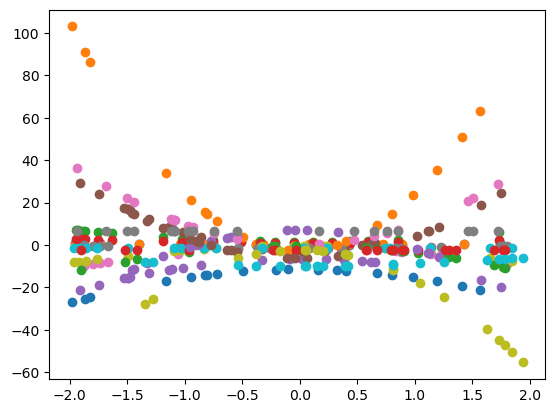

In [19]:
for i in range(N):
    plt.plot(X_train[i*p:(i+1)*p,0].detach().numpy(),Y[i*p:(i+1)*p].detach().numpy(),'o')

In [20]:
Y_mean = Y.mean()
Y_std = Y.std()

X_mean = X_train.mean()
X_std =X_train.std()

#X_train = (X_train-X_mean)/X_std
#X_test = (X_test-X_mean)/X_std

#Y=(Y-Y_mean)/Y_std
#Y_test=(Y_test-Y_mean)/Y_std

In [21]:
X_all_train = (torch.cat((X_train,torch.repeat_interleave(L_true,p,dim=0)),axis=1))
X_all_test = (torch.cat((X_test,torch.repeat_interleave(L_true,p,dim=0)),axis=1))


In [22]:
emulator=GPE.ensemble(X_all_train,Y,mean_func='zero',training_iter=1000)

0


/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(


1


In [23]:
emulator.R2(X_all_test,Y_test)

tensor([0.9999, 1.0000], grad_fn=<RsubBackward1>)

In [24]:
L =torch.normal(0,torch.ones(L_true.shape[0],L_true.shape[1])).clone().detach().requires_grad_(True)
XL_train = torch.cat((X_train,torch.repeat_interleave(L,p,dim=0)),axis=1)

In [25]:
LVemulator = LVM.LVE(XL_train,Y,0.01,p,N,1,training_iter=1000,lr=1e-4)

tensor(8373.9883, grad_fn=<NegBackward0>)


In [26]:
LVemulator.optimise(1000000,lr=1e-5)

tensor(4691.3047, grad_fn=<NegBackward0>)
tensor(3588.0161, grad_fn=<NegBackward0>)
tensor(3796.6328, grad_fn=<NegBackward0>)
tensor(3282.2031, grad_fn=<NegBackward0>)
tensor(2918.9358, grad_fn=<NegBackward0>)
tensor(2660.5596, grad_fn=<NegBackward0>)
tensor(2471.3145, grad_fn=<NegBackward0>)
tensor(2328.4199, grad_fn=<NegBackward0>)
tensor(2221.0098, grad_fn=<NegBackward0>)
tensor(2143.7673, grad_fn=<NegBackward0>)
tensor(2088.4131, grad_fn=<NegBackward0>)
tensor(2046.5365, grad_fn=<NegBackward0>)
tensor(2012.7413, grad_fn=<NegBackward0>)
tensor(1983.7205, grad_fn=<NegBackward0>)
tensor(1957.7002, grad_fn=<NegBackward0>)
tensor(1934.1509, grad_fn=<NegBackward0>)
tensor(1912.9814, grad_fn=<NegBackward0>)
tensor(1894.0653, grad_fn=<NegBackward0>)
tensor(1876.8140, grad_fn=<NegBackward0>)
tensor(1858.5251, grad_fn=<NegBackward0>)
tensor(1838.6204, grad_fn=<NegBackward0>)
tensor(1819.9758, grad_fn=<NegBackward0>)
tensor(1802.0068, grad_fn=<NegBackward0>)
tensor(1786.9205, grad_fn=<NegBack

In [47]:
torch.cat(LVemulator.Ls,axis=1).shape

torch.Size([10, 2002000])

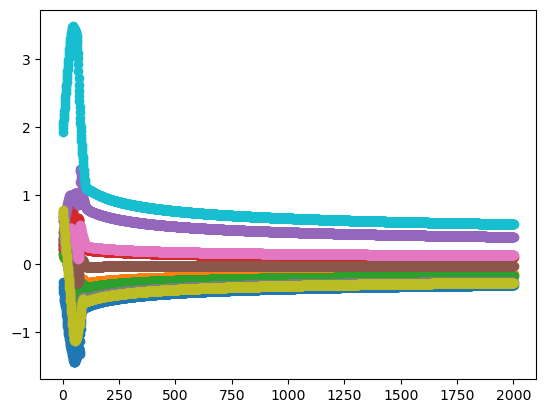

In [48]:
plt.plot(torch.cat(LVemulator.Ls,axis=1).T[::1000],'o')

In [57]:
XL_test = torch.cat((X_test,torch.repeat_interleave(LVemulator.L,p,dim=0)),axis=1)

In [58]:
LVemulator.L

tensor([[-1.5901, -0.4592],
        [ 0.0226,  1.7138],
        [-1.1303,  0.3376],
        [-0.4170, -0.9256],
        [ 0.5702,  0.2900],
        [ 1.1163,  1.0931],
        [ 0.9254, -1.3730],
        [-0.0516, -1.2485],
        [ 0.5657, -1.3967],
        [-0.0112,  1.9683]], requires_grad=True)

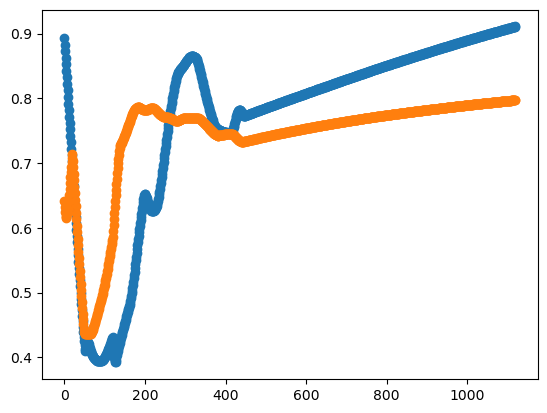

In [61]:
plt.plot(torch.cat(LVemulator.lengths,axis=1).T[::1000],'o')

In [50]:
LVemulator.predict(XL_test)

tensor([0.9111, 4.0000, 4.0000], grad_fn=<CatBackward0>)
tensor([0.7974, 4.0000, 4.0000], grad_fn=<CatBackward0>)


(tensor([[ 1.9228e-01,  2.7504e-01],
         [ 1.8828e-01,  1.6161e-01],
         [ 1.9322e-01,  2.9653e-01],
         [ 2.0279e-01, -2.1617e-01],
         [ 2.1156e-01, -5.4520e-02],
         [ 2.2839e-01,  7.2551e-01],
         [ 2.1324e-01,  6.9228e-01],
         [ 8.0623e-01,  3.2371e+00],
         [ 2.0674e-01, -2.3669e-01],
         [ 2.3856e-01,  1.0940e+00],
         [ 4.7989e-01,  2.9175e+00],
         [ 5.7390e-01,  2.7491e+00],
         [ 2.0991e-01, -2.4189e-01],
         [ 2.0692e-01,  1.7320e-01],
         [ 3.6952e-01,  1.8942e+00],
         [ 2.1028e-01,  4.8757e-05],
         [ 2.1272e-01,  6.7847e-01],
         [ 2.0941e-01,  5.7831e-01],
         [ 3.4065e-01,  1.6594e+00],
         [ 3.3320e-01,  1.8230e+00],
         [ 6.0856e-01,  9.0850e-01],
         [-4.8671e-01,  1.5501e-01],
         [ 1.1463e+00,  1.3448e+00],
         [-3.2674e-01,  2.8268e-01],
         [ 5.8214e-01,  8.8540e-01],
         [-8.0357e-02,  4.3198e-01],
         [ 9.4114e-01,  1.2283e+00],
 

In [51]:
LVemulator.lengthscale

tensor([[0.9111],
        [0.7974]], requires_grad=True)

In [52]:
LVemulator.scale

tensor([11.1841, 11.3084], requires_grad=True)

In [53]:
LVemulator.MSE(XL_test,Y_test)

tensor([0.9111, 4.0000, 4.0000], grad_fn=<CatBackward0>)
tensor([0.7974, 4.0000, 4.0000], grad_fn=<CatBackward0>)


tensor([0.0044, 0.0081], grad_fn=<MeanBackward1>)

In [54]:
LVemulator.R2(XL_test,Y_test)

tensor([0.9111, 4.0000, 4.0000], grad_fn=<CatBackward0>)
tensor([0.7974, 4.0000, 4.0000], grad_fn=<CatBackward0>)


tensor([0.9901, 0.9931], grad_fn=<RsubBackward1>)

In [60]:
Y_test.std(axis=0)

tensor([0.9837, 1.0331])

In [35]:
Y_test

tensor([[-1.0250, -1.0250],
        [-0.4678, -0.4678],
        [-2.2169, -2.2169],
        [-2.2122, -2.2122],
        [-2.0013, -2.0013],
        [-2.2786, -2.2786],
        [-1.3610, -1.3610],
        [-1.1209, -1.1209],
        [-0.5388, -0.5388],
        [-1.1221, -1.1221],
        [-2.9212, -2.9212],
        [-3.0488, -3.0488],
        [-0.7269, -0.7269],
        [-0.4919, -0.4919],
        [-0.9623, -0.9623],
        [-1.1929, -1.1929],
        [-1.8205, -1.8205],
        [-0.5970, -0.5970],
        [-2.6006, -2.6006],
        [-1.6971, -1.6971],
        [-2.5839, -2.5839],
        [ 0.2603,  0.2603],
        [-0.4646, -0.4646],
        [-0.0280, -0.0280],
        [-0.1094, -0.1094],
        [ 0.2439,  0.2439],
        [-1.8135, -1.8135],
        [-1.9327, -1.9327],
        [-0.1334, -0.1334],
        [ 0.3693,  0.3693],
        [ 0.2954,  0.2954],
        [ 0.2304,  0.2304],
        [-2.5414, -2.5414],
        [-1.0739, -1.0739],
        [-1.7298, -1.7298],
        [-2.9119, -2

In [36]:
for param_name, param in emulator.models[0].named_parameters():
    print(f'Parameter name: {param_name:42} ')

Parameter name: likelihood.noise_covar.raw_noise           
Parameter name: covar_module.raw_outputscale               
Parameter name: covar_module.base_kernel.raw_lengthscale   


In [37]:
emulator.models[0].covar_module.outputscale
emulator.models[0].covar_module.base_kernel.lengthscale

tensor([[ 1.9199,  4.0153, 32.0411]], grad_fn=<SoftplusBackward0>)

In [38]:
emulator.models[0].covar_module.outputscale.detach().clone()

tensor(45.1826)

In [39]:
rbf(X_all_train,X_all_train,1.,torch.tensor(1.))

tensor([[1.0000, 0.4176, 0.8276,  ..., 0.0959, 0.0387, 0.0927],
        [0.4176, 1.0000, 0.1533,  ..., 0.0102, 0.1527, 0.1589],
        [0.8276, 0.1533, 1.0000,  ..., 0.1502, 0.0113, 0.0397],
        ...,
        [0.0959, 0.0102, 0.1502,  ..., 1.0000, 0.0237, 0.1092],
        [0.0387, 0.1527, 0.0113,  ..., 0.0237, 1.0000, 0.8195],
        [0.0927, 0.1589, 0.0397,  ..., 0.1092, 0.8195, 1.0000]])

In [40]:
rbf(X_all_train,X_all_train,1.,torch.tensor(1.))-rbf2(X_all_train,X_all_train,1.,torch.tensor(1.))

tensor([[ 0.0000e+00,  2.4321e-01,  1.4268e-01,  ...,  8.6730e-02,
          3.7205e-02,  8.4092e-02],
        [ 2.4321e-01,  0.0000e+00,  1.2979e-01,  ...,  1.0086e-02,
          1.2941e-01,  1.3365e-01],
        [ 1.4268e-01,  1.2979e-01, -4.7684e-07,  ...,  1.2761e-01,
          1.1132e-02,  3.8166e-02],
        ...,
        [ 8.6730e-02,  1.0086e-02,  1.2761e-01,  ...,  0.0000e+00,
          2.3156e-02,  9.7266e-02],
        [ 3.7205e-02,  1.2941e-01,  1.1132e-02,  ...,  2.3156e-02,
          0.0000e+00,  1.4790e-01],
        [ 8.4092e-02,  1.3365e-01,  3.8166e-02,  ...,  9.7266e-02,
          1.4790e-01,  0.0000e+00]])

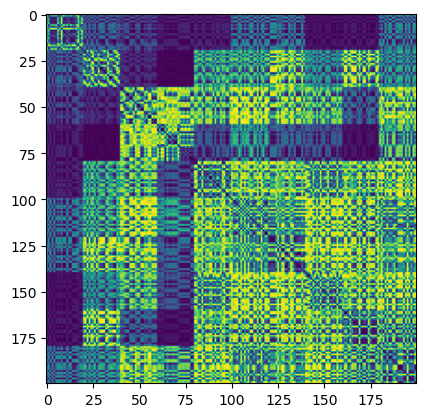

In [41]:
plt.imshow(rbf(X_all_train,X_all_train,1.,torch.tensor(1.))-rbf2(X_all_train,X_all_train,1.,torch.tensor(1.)))

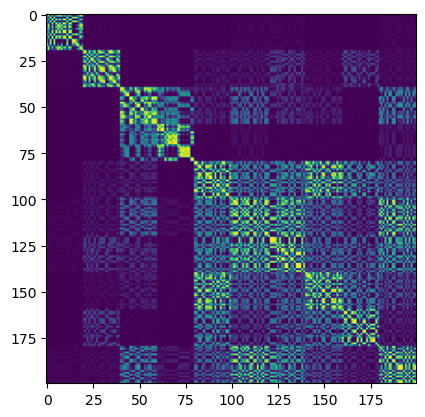

In [42]:
plt.imshow(rbf2(X_all_train,X_all_train,1.,torch.tensor(1.)))

In [43]:
emulator.R2(X_all_test,Y_test)

tensor([1.0000, 1.0000], grad_fn=<RsubBackward1>)

In [44]:
def cost(y,XL,scaling1,lengthscale1,scaling2,lengthscale2,sigma2,L_dim,mean=0):
    
    K1=rbf(XL,XL,scaling1,lengthscale1)+sigma2*torch.eye(XL.shape[0])
    K2=rbf(XL,XL,scaling2,lengthscale2)+sigma2*torch.eye(XL.shape[0])
    #K_inv=torch.kron(torch.linalg.inv(K_x),torch.linalg.inv(K_L))
    #K_inv=torch.kron(torch.linalg.inv(K_L),torch.linalg.inv(K_x))
    #print(torch.linalg.det(K))
    c = multivariate_ll(y[:,[0]],mean,K1) + multivariate_ll(y[:,[1]],mean,K2)+ multivariate_ll(XL[:,L_dim:],0,torch.eye(XL.shape[0])) # multivariate_ll(torch.repeat_interleave(L,x.shape[0])[:,None],0,torch.eye(inp.shape[0]))
    return -c

In [45]:
L = torch.rand(L_true.shape[0],L_true.shape[1]).clone().detach().requires_grad_(True)

In [46]:
L =torch.normal(0,torch.ones(L_true.shape[0],L_true.shape[1])).clone().detach().requires_grad_(True)
L_orig = L.clone().detach()
#L =L_true.clone().detach().requires_grad_(True)
scaling1 = torch.rand(1).clone().detach().requires_grad_(True)
lengthscale1 = torch.rand(X_train.shape[1]).clone().detach().requires_grad_(True)
lengthscale_in1=torch.tensor([lengthscale[0],4])

scaling2 = torch.rand(1).clone().detach().requires_grad_(True)
lengthscale2 = torch.rand(X_train.shape[1]).clone().detach().requires_grad_(True)
lengthscale_in2=torch.tensor([lengthscale[0],4])


scaling_true1 = emulator.models[0].covar_module.outputscale.detach().clone().requires_grad_(True)#torch.rand(1).clone().detach().requires_grad_(True)
lengthscale_true1 = torch.rand(X_train.shape[1]).clone().detach().requires_grad_(True)

scaling_true2 = emulator.models[1].covar_module.outputscale.detach().clone().requires_grad_(True)#torch.rand(1).clone().detach().requires_grad_(True)
lengthscale_true2 = emulator.models[1].covar_module.base_kernel.lengthscale.detach().clone().requires_grad_(True) #torch.rand(X_train.shape[1]+L_true.shape[1]).clone().detach().requires_grad_(True)

#lengthscale=lengthscale_true.clone().detach().requires_grad_(True)
#scaling=scaling_true.clone().detach().requires_grad_(True)

sigma2 = torch.tensor([0.001]).clone().detach().requires_grad_(True)
mean = torch.rand(1).clone().detach().requires_grad_(True)
mean=0

NameError: name 'lengthscale' is not defined

In [ ]:
XL_test = torch.cat((X_test,torch.repeat_interleave(L_true,p,dim=0)),axis=1)
XL_train = torch.cat((X_train,torch.repeat_interleave(L,p,dim=0)),axis=1)

XL_true_test = torch.cat((X_test,torch.repeat_interleave(L_true,p,dim=0)),axis=1)
XL_true_train = torch.cat((X_train,torch.repeat_interleave(L_true,p,dim=0)),axis=1)

In [ ]:
for i in range(L.shape[0]):
    m_p,K_p = posterior_theta(Y,XL_test[i*p:(i+1)*p],XL_train,scaling,lengthscale,sigma2,mean)
    R2=1-((m_p*Y_std+Y_mean-(Y_test[i*p:(i+1)*p,:]*Y_std+Y_mean))**2).mean(axis=0)/(Y_test[i*p:(i+1)*p,:]*Y_std+Y_mean).std(axis=0)**2
    print(R2,((m_p*Y_std+Y_mean-(Y_test[i*p:(i+1)*p,:]*Y_std+Y_mean))**2).mean(axis=0),(Y_test[i*p:(i+1)*p,:]*Y_std+Y_mean).std(axis=0)**2)

In [ ]:
for i in range(L.shape[0]):
    m_p,K_p = posterior_theta(Y[:,0],XL_true_test[i*p:(i+1)*p],XL_true_train,scaling_true1,lengthscale_true1,sigma2,mean)
    R2=1-((m_p*Y_std+Y_mean-(Y_test[i*p:(i+1)*p,0]*Y_std+Y_mean))**2).mean(axis=0)/(Y_test[i*p:(i+1)*p,0]*Y_std+Y_mean).std(axis=0)**2
    print(R2,((m_p*Y_std+Y_mean-(Y_test[i*p:(i+1)*p,0]*Y_std+Y_mean))**2).mean(axis=0),(Y_test[i*p:(i+1)*p,0]*Y_std+Y_mean).std(axis=0)**2)

In [ ]:
m_p,K_p = posterior_theta(Y,XL_test,XL_train,scaling,lengthscale,sigma2,mean)
R2=1-((m_p*Y_std+Y_mean-(Y_test*Y_std+Y_mean))**2).mean(axis=0)/(Y_test*Y_std+Y_mean).std(axis=0)**2
print(R2,((m_p*Y_std+Y_mean-(Y_test*Y_std+Y_mean))**2).mean(axis=0),(Y_test*Y_std+Y_mean).std(axis=0)**2)

In [ ]:
m_p,K_p = posterior_theta(Y,XL_true_test,XL_true_train,scaling_true,lengthscale_true,sigma2,mean)
R2=1-((m_p*Y_std+Y_mean-(Y_test*Y_std+Y_mean))**2).mean(axis=0)/(Y_test*Y_std+Y_mean).std(axis=0)**2
print(R2,((m_p*Y_std+Y_mean-(Y_test*Y_std+Y_mean))**2).mean(axis=0),(Y_test*Y_std+Y_mean).std(axis=0)**2)

In [ ]:
cost(Y,XL_train,scaling1,lengthscale1,scaling2,lengthscale2,sigma2,L_dim=1)

In [ ]:
gd = torch.optim.SGD([scaling_true1,lengthscale_true], lr=1e-5)
history_gd = []

for i in range(100000):
    gd.zero_grad()
    objective = cost(Y,XL_true_train,scaling_true,lengthscale_true,sigma2,L_dim=1)
    objective.backward()
    gd.step()
    history_gd.append(objective.item())
    if i%100 ==0:
        print(objective)
    if (i>1) and (np.abs(history_gd[-1] - history_gd[-2]) < .00000000000001):
        print("Convergence achieved in ", i+1, " iterations") 
        print("-LogL Value: ", objective.item())
        break


## lengthscale=4

In [ ]:
history_gd = []
scales=[]
lengths=[]
Ls=[]

In [ ]:
L =torch.normal(0,torch.ones(L_true.shape[0],L_true.shape[1])).clone().detach().requires_grad_(True)
scaling1 = (2*torch.rand(1)).clone().detach().requires_grad_(True)
lengthscale1 = (2*torch.rand(X_train.shape[1])).clone().detach().requires_grad_(True)
lengthscale_in1=torch.cat([lengthscale,torch.tensor([4])])

scaling2 = (2*torch.rand(1)).clone().detach().requires_grad_(True)
lengthscale2 = (2*torch.rand(X_train.shape[1])).clone().detach().requires_grad_(True)
lengthscale_in2=torch.cat([lengthscale,torch.tensor([4])])

In [ ]:
gd = torch.optim.Adam([L,scaling1,lengthscale1,scaling2,lengthscale2], lr=1e-5)
for i in range(1000000):
    lengthscale_in1=torch.cat([lengthscale1,torch.tensor([4,4])])
    lengthscale_in2=torch.cat([lengthscale2,torch.tensor([4,4])])
    gd.zero_grad()
    objective = cost(Y,XL_train,scaling1,lengthscale_in1,scaling2,lengthscale_in2,sigma2,L_dim=1)
    objective.backward()
    gd.step()
    history_gd.append(objective.item())
    scales.append(scaling.clone().detach())
    lengths.append(lengthscale.clone().detach())
    Ls.append(L.clone().detach())
    XL_train = torch.cat((X_train,torch.repeat_interleave(L,p,dim=0)),axis=1)
    
    if i%1000 ==0:
        XL_test = torch.cat((X_test,torch.repeat_interleave(L,p,dim=0)),axis=1)
        m_p,K_p = posterior_theta(Y,XL_test,XL_train,scaling1,lengthscale_in1,sigma2,mean)
        R2=1-((m_p*Y_std+Y_mean-(Y_test*Y_std+Y_mean))**2).mean(axis=0)/(Y_test*Y_std+Y_mean).std(axis=0)**2
        print(objective,R2,scaling)
        
    #if (i>1) and (np.abs(history_gd[-1] - history_gd[-2]) < .000000000000000000000001):
        #print("Convergence achieved in ", i+1, " iterations") 
        #print("-LogL Value: ", objective.item())
        #break

In [ ]:
plt.plot(history_gd)

In [ ]:
torch.cat(Ls,axis=0).shape

In [ ]:
plt.plot(torch.cat(Ls,axis=0).detach().numpy(),'o')

In [ ]:
torch.cat(lengths).shape

In [ ]:
plt.plot(torch.cat(lengths).detach().numpy(),'o')

In [ ]:
m_p2,K_p = posterior_theta(Y,XXLL,XL_train,scaling,lengthscale,sigma2,mean)
plt.imshow(m_p2.reshape(100,100).detach().numpy(),origin='lower',extent=[lmin,lmax,xmin,xmax])
plt.plot(XL_train[0:10,1].detach().numpy(),XL_train[0:10,0].detach().numpy(),'o',color='r')
#plt.plot(XL_test[:,1].detach().numpy(),XL_test[:,0].detach().numpy(),'o',color='b')
plt.colorbar() 

In [ ]:
m_p,K_p = posterior_theta(Y,XXLL,XL_true_train,scaling_true,lengthscale_true,sigma2,mean)
plt.imshow(m_p.reshape(100,100).detach().numpy(),origin='lower',extent=[lmin,lmax,xmin,xmax])
plt.plot(XL_true_train[0:10,1].detach().numpy(),XL_true_train[0:10,0].detach().numpy(),'o',color='r')
#plt.plot(XL_test[:,1].detach().numpy(),XL_test[:,0].detach().numpy(),'o',color='b')
plt.colorbar() 

## lengthscale=1

In [ ]:
history_gd = []
scales=[]
lengths=[]
Ls=[]

In [ ]:
L =torch.normal(0,torch.ones(L_true.shape[0],L_true.shape[1])).clone().detach().requires_grad_(True)
scaling = (2*torch.rand(1)).clone().detach().requires_grad_(True)
lengthscale = (2*torch.rand(X_train.shape[1])).clone().detach().requires_grad_(True)
lengthscale_in=torch.cat([lengthscale,torch.tensor([4])])


In [ ]:
gd = torch.optim.Adam([L,scaling,lengthscale], lr=1e-5)
for i in range(1000000):
    lengthscale_in=torch.cat([lengthscale,torch.tensor([1])])
    gd.zero_grad()
    objective = cost(Y,XL_train,scaling,lengthscale_in,sigma2,L_dim=1)
    objective.backward()
    gd.step()
    history_gd.append(objective.item())
    scales.append(scaling.clone().detach())
    lengths.append(lengthscale.clone().detach())
    Ls.append(L.clone().detach())
    XL_train = torch.cat((X_train,torch.repeat_interleave(L,p,dim=0)),axis=1)
    
    if i%1000 ==0:
        XL_test = torch.cat((X_test,torch.repeat_interleave(L,p,dim=0)),axis=1)
        m_p,K_p = posterior_theta(Y,XL_test,XL_train,scaling,lengthscale_in,sigma2,mean)
        R2=1-((m_p*Y_std+Y_mean-(Y_test*Y_std+Y_mean))**2).mean(axis=0)/(Y_test*Y_std+Y_mean).std(axis=0)**2
        print(objective,R2,scaling)
        
    #if (i>1) and (np.abs(history_gd[-1] - history_gd[-2]) < .000000000000000000000001):
        #print("Convergence achieved in ", i+1, " iterations") 
        #print("-LogL Value: ", objective.item())
        #break

In [ ]:
plt.plot(history_gd)

In [ ]:
torch.cat(Ls,axis=1)

In [ ]:
plt.plot(torch.cat(Ls,axis=1).T.detach().numpy())

In [ ]:
torch.cat(lengths).shape

In [ ]:
plt.plot(torch.cat(lengths).detach().numpy(),'o')

In [ ]:
m_p2,K_p = posterior_theta(Y,XXLL,XL_train,scaling,lengthscale,sigma2,mean)
plt.imshow(m_p2.reshape(100,100).detach().numpy(),origin='lower',extent=[lmin,lmax,xmin,xmax])
plt.plot(XL_train[30:40,1].detach().numpy(),XL_train[30:40,0].detach().numpy(),'o',color='r')
#plt.plot(XL_test[:,1].detach().numpy(),XL_test[:,0].detach().numpy(),'o',color='b')
plt.colorbar() 

In [ ]:
m_p,K_p = posterior_theta(Y,XXLL,XL_true_train,scaling_true,lengthscale_true,sigma2,mean)
plt.imshow(m_p.reshape(100,100).detach().numpy(),origin='lower',extent=[lmin,lmax,xmin,xmax])
plt.plot(XL_true_train[30:40,1].detach().numpy(),XL_true_train[30:40,0].detach().numpy(),'o',color='r')
#plt.plot(XL_test[:,1].detach().numpy(),XL_test[:,0].detach().numpy(),'o',color='b')
plt.colorbar() 

## Can we get to the true values?

In [ ]:
history_gd = []
scales=[]
lengths=[]
Ls=[]

In [ ]:
L =torch.normal(0,torch.ones(L_true.shape[0],L_true.shape[1])).clone().detach().requires_grad_(True)
scaling = (torch.rand(1)).clone().detach().requires_grad_(True)
lengthscale = torch.rand(X_train.shape[1]+L_true.shape[1]).clone().detach().requires_grad_(True)

In [ ]:
gd = torch.optim.Adam([scaling,lengthscale], lr=1e-5)
for i in range(500000):
    gd.zero_grad()
    objective = cost(Y,XL_true_train,scaling,lengthscale,sigma2,L_dim=1)
    objective.backward()
    gd.step()
    history_gd.append(objective.item())
    scales.append(scaling.clone().detach())
    lengths.append(lengthscale.clone().detach())
    Ls.append(L.clone().detach())
    
    if i%1000 ==0:
        m_p,K_p = posterior_theta(Y,XL_true_test,XL_true_train,scaling,lengthscale,sigma2,mean)
        R2=1-((m_p*Y_std+Y_mean-(Y_test*Y_std+Y_mean))**2).mean(axis=0)/(Y_test*Y_std+Y_mean).std(axis=0)**2
        print(objective,R2,scaling)
        
    #if (i>1) and (np.abs(history_gd[-1] - history_gd[-2]) < .000000000000000000000001):
        #print("Convergence achieved in ", i+1, " iterations") 
        #print("-LogL Value: ", objective.item())
        #break

In [ ]:
plt.plot(history_gd)

In [ ]:
torch.cat(Ls,axis=1)

In [ ]:
plt.plot(torch.cat(Ls,axis=1).T.detach().numpy())

In [ ]:
torch.cat(lengths).shape

In [ ]:
plt.plot(torch.cat(lengths).detach().numpy(),'o')

In [ ]:
m_p2,K_p = posterior_theta(Y,XXLL,XL_true_train,scaling,lengthscale,sigma2,mean)
plt.imshow(m_p2.reshape(100,100).detach().numpy(),origin='lower',extent=[lmin,lmax,xmin,xmax])
plt.plot(XL_true_train[30:40,1].detach().numpy(),XL_true_train[30:40,0].detach().numpy(),'o',color='r')
#plt.plot(XL_test[:,1].detach().numpy(),XL_test[:,0].detach().numpy(),'o',color='b')
plt.colorbar() 

In [ ]:
m_p,K_p = posterior_theta(Y,XXLL,XL_true_train,scaling_true,lengthscale_true,sigma2,mean)
plt.imshow(m_p.reshape(100,100).detach().numpy(),origin='lower',extent=[lmin,lmax,xmin,xmax])
plt.plot(XL_true_train[30:40,1].detach().numpy(),XL_true_train[30:40,0].detach().numpy(),'o',color='r')
#plt.plot(XL_test[:,1].detach().numpy(),XL_test[:,0].detach().numpy(),'o',color='b')
plt.colorbar() 

In [ ]:
plt.plot(torch.tensor(scales).detach().numpy())

In [ ]:
scaling_true

In [ ]:
scaling

In [ ]:
Y_test.std()

In [ ]:

print(R2,((m_p*Y_std+Y_mean-(Y_test*Y_std+Y_mean))**2).mean(axis=0),(Y_test*Y_std+Y_mean).std(axis=0)**2)

In [ ]:
m_p,K_p = posterior_theta(Y,XL_true_test,XL_true_train,scaling_true,lengthscale_true,sigma2,mean)
R2=1-((m_p*Y_std+Y_mean-(Y_test*Y_std+Y_mean))**2).mean(axis=0)/(Y_test*Y_std+Y_mean).std(axis=0)**2
print(R2,((m_p*Y_std+Y_mean-(Y_test*Y_std+Y_mean))**2).mean(axis=0),(Y_test*Y_std+Y_mean).std(axis=0)**2)

In [ ]:
m_p,K_p = posterior_theta(Y,XL_train,XL_train,scaling,lengthscale,sigma2,mean)
R2=1-((m_p*Y_std+Y_mean-(Y*Y_std+Y_mean))**2).mean(axis=0)/(Y*Y_std+Y_mean).std(axis=0)**2
print(R2,((m_p*Y_std+Y_mean-(Y*Y_std+Y_mean))**2).mean(axis=0),(Y*Y_std+Y_mean).std(axis=0)**2)

In [ ]:
m_p,K_p = posterior_theta(Y,XL_true_train,XL_true_train,scaling_true,lengthscale_true,sigma2,mean)
R2=1-((m_p*Y_std+Y_mean-(Y*Y_std+Y_mean))**2).mean(axis=0)/(Y*Y_std+Y_mean).std(axis=0)**2
print(R2,((m_p*Y_std+Y_mean-(Y*Y_std+Y_mean))**2).mean(axis=0),(Y*Y_std+Y_mean).std(axis=0)**2)

In [ ]:
m_p,K_p = posterior_theta(Y,XXLL,XL_true_train,scaling,lengthscale,sigma2,mean)

In [ ]:
XXLL.min(axis=0)

In [ ]:
m_p,K_p = posterior_theta(Y,XXLL,XL_true_train,scaling_true,lengthscale_true,sigma2,mean)
plt.imshow(m_p.reshape(100,100).detach().numpy(),origin='lower',extent=[lmin,lmax,xmin,xmax])
plt.plot(XL_true_train[:,1].detach().numpy(),XL_true_train[:,0].detach().numpy(),'o',color='r')
#plt.plot(XL_test[:,0].detach().numpy(),XL_test[:,1].detach().numpy(),'o',color='b')
plt.colorbar()

In [ ]:
XL_train

In [ ]:



m_p2,K_p = posterior_theta(Y,XXLL,XL_train,scaling,lengthscale,sigma2,mean)
plt.imshow(m_p2.reshape(100,100).detach().numpy(),origin='lower',extent=[lmin,lmax,xmin,xmax])
plt.plot(XL_train[:,1].detach().numpy(),XL_test[:,0].detach().numpy(),'o',color='r')
#plt.plot(XL_test[:,1].detach().numpy(),XL_test[:,0].detach().numpy(),'o',color='b')
plt.colorbar() 

In [ ]:
lengthscale

In [ ]:
L

In [ ]:
scaling

In [ ]:
lengthscale_true

In [ ]:
m_p,K_p = posterior_theta(Y,XXLL,XL_true_train,scaling_true,lengthscale_true,sigma2,mean)
plt.imshow((m_p.reshape(100,100).detach().numpy()-m_p2.reshape(100,100).detach().numpy())**2,origin='lower',extent=[lmin,lmax,xmin,xmax])
#plt.plot(XL_train[:,0].detach().numpy(),XL_train[:,1].detach().numpy(),'o',color='r')
#plt.plot(XL_test[:,0].detach().numpy(),XL_test[:,1].detach().numpy(),'o',color='b')
plt.colorbar()

In [ ]:
plt.imshow(emulator.predict(XXLL).reshape(100,100).detach().numpy(),origin='lower',extent=[lmin,lmax,xmin,xmax])
plt.colorbar()

In [ ]:
m_p,K_p = posterior_theta(Y,XXLL,XL_true_train,scaling_true,lengthscale_true,sigma2,mean)
plt.imshow(m_p.reshape(100,100).detach().numpy()-emulator.predict(XXLL).reshape(100,100).detach().numpy(),origin='lower',extent=[lmin,lmax,xmin,xmax])
plt.colorbar()

In [ ]:
L_true

In [ ]:
L

In [ ]:
for i in range(L.shape[0]):
    m_p,K_p = posterior_theta(Y,XL_test[i*p:(i+1)*p],XL_train,scaling,lengthscale,sigma2,mean)
    R2=1-((m_p*Y_std+Y_mean-(Y_test[i*p:(i+1)*p,:]*Y_std+Y_mean))**2).mean(axis=0)/(Y_test[i*p:(i+1)*p,:]*Y_std+Y_mean).std(axis=0)**2
    print(R2,((m_p*Y_std+Y_mean-(Y_test[i*p:(i+1)*p,:]*Y_std+Y_mean))**2).mean(axis=0),(Y_test[i*p:(i+1)*p,:]*Y_std+Y_mean).std(axis=0)**2)

In [ ]:
for i in range(L.shape[0]):
    m_p,K_p = posterior_theta(Y,XL_test[i*p:(i+1)*p],XL_train,scaling,lengthscale,sigma2,mean)
    R2=1-((m_p-(Y_test[i*p:(i+1)*p,:]))**2).mean(axis=0)/(Y_test[i*p:(i+1)*p,:]).std(axis=0)**2
    print(R2,((m_p*Y_std+Y_mean-(Y_test[i*p:(i+1)*p,:]*Y_std+Y_mean))**2).mean(axis=0),(Y_test[i*p:(i+1)*p,:]*Y_std+Y_mean).std(axis=0)**2)

### Test 2

In [ ]:
N = 10 #number of systems
p = 20 #observations per system
alpha=10
beta=-7
zeta=5

In [ ]:
L_true=torch.FloatTensor(N, 2).uniform_(-1, 1)

In [ ]:
L_true[0]

In [ ]:
multivariate_ll(L_true,0,torch.eye(N),K_inv=None)

In [ ]:

import scipy
np.sum(scipy.stats.multivariate_normal.logpdf(L_true.T.detach().numpy(),cov=np.eye(N)))

In [ ]:
X_train=torch.torch.FloatTensor(N*p, 2).uniform_(-1, 1)
X_test=torch.torch.FloatTensor(N*p, 2).uniform_(-1, 1)

In [ ]:
L_true[[0]][0]

In [ ]:
def true_func(X,L,alpha,beta,zeta):
    tf = alpha*X[:,[0]]*X[:,[ 0]]*L[:,0]+beta*L[:,1]*X[:,[ 1]]+zeta+torch.normal(0,0.01*torch.ones(X.shape[0],1))
    return tf

In [ ]:
y=[]
y_test = []
for i in range(N):
    y.append(true_func(X_train[i*p:(i+1)*p],L_true[[i]],alpha,beta,zeta))
    y_test.append(true_func(X_test[i*p:(i+1)*p],L_true[[i]],alpha,beta,zeta))

In [ ]:
Y=torch.cat(y)
Y_test=torch.cat(y_test)

In [ ]:
Y.shape

In [ ]:
Y_mean = Y.mean()
Y_std = Y.std()

X_mean = X_train.mean()
X_std =X_train.std()

X_train = (X_train-X_mean)/X_std
X_test = (X_test-X_mean)/X_std

In [ ]:
X_train[i*p:(i+1)*p,0].shape

In [ ]:
emulators=[]
for i in range(N):
    emulators.append(GPE.ensemble(X_train[i*p:(i+1)*p,:],Y[i*p:(i+1)*p],mean_func='zero'))

In [ ]:
for i in range(N):
    print(emulators[i].R2(X_test[i*p:(i+1)*p,:],(Y_test[i*p:(i+1)*p])))

In [ ]:
Y=(Y-Y_mean)/Y_std
Y_test=(Y_test-Y_mean)/Y_std

In [ ]:
def cost(y,X,L,scaling,lengthscale,sigma2,p,mean=0):
    

    K=rbf(X,L,X,L,scaling,lengthscale,p,p)+sigma2*torch.eye(X.shape[0])
    
    #K_inv=torch.kron(torch.linalg.inv(K_x),torch.linalg.inv(K_L))
    #K_inv=torch.kron(torch.linalg.inv(K_L),torch.linalg.inv(K_x))
    #print(torch.linalg.det(K))
    c = multivariate_ll(y,mean,K) + multivariate_ll(L,0,torch.eye(L.shape[0])) # multivariate_ll(torch.repeat_interleave(L,x.shape[0])[:,None],0,torch.eye(inp.shape[0]))
    return -c

In [ ]:
L = torch.rand(L_true.shape[0],L_true.shape[1]).clone().detach().requires_grad_(True)

In [ ]:
L =torch.normal(0,torch.ones(L_true.shape[0],L_true.shape[1])).clone().detach().requires_grad_(True)
#L =L_true.clone().detach().requires_grad_(True)
scaling = torch.rand(1).clone().detach().requires_grad_(True)
lengthscale = torch.rand(X_train.shape[1]+L_true.shape[1]).clone().detach().requires_grad_(True)
sigma2 = torch.tensor([0.000001]).clone().detach().requires_grad_(True)
mean = torch.rand(1).clone().detach().requires_grad_(True)
mean=0

In [ ]:
for i in range(L.shape[0]):
    m_p,K_p = posterior_theta(Y[i*p:(i+1)*p],X_test[i*p:(i+1)*p],L[[i]],p,X_train[i*p:(i+1)*p],L[[i]],p,scaling,lengthscale,sigma2,mean)
    R2=1-((m_p*Y_std+Y_mean-(Y_test[i*p:(i+1)*p,:]*Y_std+Y_mean))**2).mean(axis=0)/(Y_test[i*p:(i+1)*p,:]*Y_std+Y_mean).std(axis=0)**2
    print(R2)

In [ ]:
cost(Y,X_train,L,scaling,lengthscale,sigma2,p)

In [ ]:
#plt.imshow(rbf(X,L,X,L,scaling,lengthscale,p,p).detach().numpy())

In [ ]:
plt.imshow(rbf(X_train,L,X_train,L,scaling,lengthscale,p,p).detach().numpy())

In [ ]:
for i in range(N):
    plt.plot(X_train[i*p:(i+1)*p,0],Y[i*p:(i+1)*p],'o')

In [ ]:
cost(Y,X_train,L_true,scaling,lengthscale,sigma2,p)

In [ ]:
gd = torch.optim.Adam([L,scaling,lengthscale], lr=1e-5)
history_gd = []

for i in range(100000):
    gd.zero_grad()
    objective = cost(Y,X_train,L,scaling,lengthscale,sigma2,p)
    objective.backward()
    gd.step()
    history_gd.append(objective.item())
    if i%1000 ==0:
        print(objective)
    if (i>1) and (np.abs(history_gd[-1] - history_gd[-2]) < .0000000000000000000001):
        print("Convergence achieved in ", i+1, " iterations") 
        print("-LogL Value: ", objective.item())
        break


In [ ]:
L_true

In [ ]:
L

In [ ]:
lengthscale


In [ ]:
cost(Y,X_train,L_true,scaling,lengthscale,sigma2,p,mean)

In [ ]:
cost(Y,X_train,L,scaling,lengthscale,sigma2,p,mean)

In [ ]:
mean

In [ ]:
m_p,K_p = posterior_theta(Y,X_test,L,p,X_train,L,p,scaling,lengthscale,sigma2,mean)
R2=1-((m_p*Y_std+Y_mean-(Y_test*Y_std+Y_mean))**2).mean(axis=0)/(Y_test*Y_std+Y_mean).std(axis=0)**2
print(R2)

In [ ]:
X_test[i*p:(i+1)*p:,].shape

In [ ]:
for i in range(L.shape[0]):
    m_p,K_p = posterior_theta(Y,X_test[i*p:(i+1)*p],L[[i]],p,X_train,L,p,scaling,lengthscale,sigma2,mean)
    R2=1-((m_p*Y_std+Y_mean-(Y_test[i*p:(i+1)*p,:]*Y_std+Y_mean))**2).mean(axis=0)/(Y_test[i*p:(i+1)*p,:]*Y_std+Y_mean).std(axis=0)**2
    print(R2)

In [ ]:
for i in range(L.shape[0]):
    m_p,K_p = posterior_theta(Y,X_test[i*p:(i+1)*p],L_true[[i]],p,X_train,L_true,p,scaling,lengthscale,sigma2,mean)
    R2=1-((m_p*Y_std+Y_mean-(Y_test[i*p:(i+1)*p,:]*Y_std+Y_mean))**2).mean(axis=0)/(Y_test[i*p:(i+1)*p,:]*Y_std+Y_mean).std(axis=0)**2
    print(R2)

In [ ]:
for i in range(N):
    print(emulators[i].R2(X_test[i*p:(i+1)*p,:],(Y_test[i*p:(i+1)*p])*Y_std+Y_mean))


In [ ]:
cost(Y,X_train,L,scaling,lengthscale,sigma2,p)

In [ ]:
cost(Y,X_train,L_true,scaling,lengthscale,sigma2,p)

In [ ]:
#plt.imshow(rbf(X,L,X,L,scaling,lengthscale,p,p).detach().numpy())

In [ ]:
plt.imshow(rbf(X_train,L,X_train,L,scaling,lengthscale,p,p).detach().numpy())

In [ ]:
for i in range(N):
    plt.plot(X_train[i*p:(i+1)*p,0],Y[i*p:(i+1)*p],'o')

In [ ]:
cost(Y,X_train,L_true,scaling,lengthscale,sigma2,p)

In [ ]:
gd = torch.optim.Adam([L,scaling,lengthscale], lr=1e-5)
history_gd = []

for i in range(100000):
    gd.zero_grad()
    objective = cost(Y,X_train,L,scaling,lengthscale,sigma2,p)
    objective.backward()
    gd.step()
    history_gd.append(objective.item())
    if i%1000 ==0:
        print(objective)
    if (i>1) and (np.abs(history_gd[-1] - history_gd[-2]) < .00000001):
        print("Convergence achieved in ", i+1, " iterations") 
        print("-LogL Value: ", objective.item())
        break


In [ ]:
L_true

In [ ]:
L

In [ ]:
m_p,K_p = posterior_theta(Y,X_test,L,p,X_train,L,p,scaling,lengthscale,sigma2,mean)
R2=1-((m_p*Y_std+Y_mean-(Y_test*Y_std+Y_mean))**2).mean(axis=0)/(Y_test*Y_std+Y_mean).std(axis=0)**2
print(R2)

In [ ]:
X_test[i*p:(i+1)*p:,].shape

In [ ]:
for i in range(L.shape[0]):
    m_p,K_p = posterior_theta(Y[i*p:(i+1)*p],X_test[i*p:(i+1)*p],L[[i]],p,X_train[i*p:(i+1)*p],L[[i]],p,scaling,lengthscale,sigma2,mean)
    R2=1-((m_p*Y_std+Y_mean-(Y_test[i*p:(i+1)*p,:]*Y_std+Y_mean))**2).mean(axis=0)/(Y_test[i*p:(i+1)*p,:]*Y_std+Y_mean).std(axis=0)**2
    print(m_p[0],R2)

In [ ]:
for i in range(L.shape[0]):
    m_p,K_p = posterior_theta(Y[i*p:(i+1)*p],X_test[i*p:(i+1)*p],L_true[[i]],p,X_train[i*p:(i+1)*p],L_true[[i]],p,scaling,lengthscale,sigma2,mean)
    R2=1-((m_p*Y_std+Y_mean-(Y_test[i*p:(i+1)*p,:]*Y_std+Y_mean))**2).mean(axis=0)/(Y_test[i*p:(i+1)*p,:]*Y_std+Y_mean).std(axis=0)**2
    print(m_p[0],R2)

In [ ]:
for i in range(N):
    print(emulators[i].R2(X_test[i*p:(i+1)*p,:],(Y_test[i*p:(i+1)*p])*Y_std+Y_mean))


In [ ]:
p_new = 20
X_new=torch.torch.FloatTensor(p_new, 1).uniform_(-1, 1)
L_new =torch.normal(0,torch.ones(1,L_true.shape[1]))
#L_new=L_true[[1]]
Y_new=true_func(X_new,L_new,alpha,beta,zeta)

Y_new_mean = Y_new.mean()
Y_new_std = Y_new.std()

Y_new = (Y_new-Y_mean)/Y_std

In [ ]:
plt.plot(X_new[:,0].detach().numpy(),Y_new.detach().numpy(),'o')

In [ ]:
def cf_cost(Y_new,X_new,L_new,Y_train,X_train,L_train,scaling,lengthscale,sigma2,p_train,p_new,mean):
    
    
    mean_p,K_p = posterior_theta(Y_train,X_new,L_new,p_new,X_train,L_train,p_train,scaling,lengthscale,sigma2,mean)
    
    #K_inv=torch.kron(torch.linalg.inv(K_x),torch.linalg.inv(K_L))
    #K_inv=torch.kron(torch.linalg.inv(K_L),torch.linalg.inv(K_x))
    #print(torch.linalg.det(K))
    c = multivariate_ll(Y_new,mean_p,K_p)  + multivariate_ll(L_new,0,torch.eye(L_new.shape[0])) # multivariate_ll(torch.repeat_interleave(L,x.shape[0])[:,None],0,torch.eye(inp.shape[0]))
    #print(multivariate_ll(Y_new,mean_p,K_p))
    #print(multivariate_ll(L_new,0,torch.eye(L_new.shape[0])))
    return -c

In [ ]:
cf_cost(Y_new,X_new,L_new,Y,X_train,L,scaling,lengthscale,sigma2,p,p_new,mean)

In [ ]:
mean_p,K_p = posterior_theta(Y,X_new,L_cf,p_new,X_train,L,p,scaling,lengthscale,sigma2,mean)

In [ ]:
plt.imshow(K_p.detach().numpy())

In [ ]:
mean_p

In [ ]:
Y_new

In [ ]:
L_cf =torch.normal(0,torch.ones(1,L_true.shape[1])).clone().detach().requires_grad_(True)
#L_cf = (L[[1]]).clone().detach().requires_grad_(True)

In [ ]:
cf_cost(Y_new,X_new,L_cf,Y,X_train,L,scaling,lengthscale,sigma2,p,p_new,mean)

In [ ]:

cf = torch.optim.Adam([L_cf], lr=1e-5)
history_cf = []

for i in range(100000):
    cf.zero_grad()
    objective = cf_cost(Y_new,X_new,L_cf,Y,X_train,L,scaling,lengthscale,sigma2,p,p_new,mean)
    objective.backward()
    cf.step()
    history_cf.append(objective.item())
    if i%1000 ==0:
        m_new, K_new = posterior_theta(Y,X_new,L_cf,p_new,X_train,L,p,scaling,lengthscale,sigma2,mean)
        print(1-(((m_new-Y_new)**2).mean()/Y_new.std()**2),objective)

    if (i>1) and (np.abs(history_cf[-1] - history_cf[-2]) < .00000000001):
        print("Convergence achieved in ", i+1, " iterations")
        print("-LogL Value: ", objective.item())
        break


In [ ]:
L_cf

In [ ]:
L[[1]]

In [ ]:
m_new, K_new = posterior_theta(Y,X_new,L_cf,p_new,X_train,L,p,scaling,lengthscale,sigma2,mean)

In [ ]:
K_new.detach().numpy()

In [ ]:
multivariate_ll(Y_new,m_new, K_new) + multivariate_ll(L_cf,0,torch.eye(L_new.shape[0]))

In [ ]:
multivariate_ll(Y_new,m_new, K_new) 

In [ ]:
multivariate_ll(L_cf,0,torch.eye(L_new.shape[0]))

In [ ]:
1-(((m_new-Y_new)**2).mean())/Y_new.std()

In [ ]:
m_new

In [ ]:
Y_new

In [ ]:
mean